In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
data=pd.read_csv('/content/drive/MyDrive/Stage/CSV-03-11/03-11/data_combined.csv',parse_dates=['Timestamp'])

In [ ]:
data.head(10)

,Timestamp
0,2018-11-03 10:09:00.565557
1,2018-11-03 10:09:00.565559
2,2018-11-03 10:09:00.565608
3,2018-11-03 10:09:00.565993
4,2018-11-03 10:09:00.565994
5,2018-11-03 10:09:00.566043
6,2018-11-03 10:09:00.566303
7,2018-11-03 10:09:00.566305
8,2018-11-03 10:09:00.566354
9,2018-11-03 10:09:00.566568


In [ ]:
data.columns

Index(['Timestamp'], dtype='object')

In [ ]:
#data.set_index('Timestamp',inplace=True)

In [ ]:
data.head(4)

,Timestamp
0,2018-11-03 10:09:00.565557
1,2018-11-03 10:09:00.565559
2,2018-11-03 10:09:00.565608
3,2018-11-03 10:09:00.565993


In [ ]:
# Renommer la colonne pour supprimer les espaces autour de 'Timestamp'
#data.rename(columns=lambda x: x.strip(), inplace=True)

# Convertir la colonne Timestamp en datetime
#data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')

# Filtrer les lignes avec des valeurs NaT résultant de la conversion incorrecte
#data = data.dropna(subset=['Timestamp'])

# Ajouter une colonne 'hour_minute_second' en extrayant l'heure, la minute et la seconde (sans la date)
data['hour_minute_second'] = data['Timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Compter le nombre d'attaques par hour_minute_second
hour_minute_second_attacks = data.groupby('hour_minute_second').size().reset_index(name='y')

# Renommer la colonne 'hour_minute_second' en 'ds' pour Prophet
hour_minute_second_attacks.rename(columns={'hour_minute_second': 'ds'}, inplace=True)

# Afficher les premières lignes pour vérifier
print(hour_minute_second_attacks.head(len(hour_minute_second_attacks)))

# Mise à jour du dataframe principal
data = hour_minute_second_attacks

                        ds  y
0      2018-11-03 09:18:16  1
1      2018-11-03 09:18:18  8
2      2018-11-03 09:18:19  1
3      2018-11-03 09:18:20  3
4      2018-11-03 09:18:26  6
...                    ... ..
12219  2018-11-03 17:36:22  2
12220  2018-11-03 17:36:28  1
12221  2018-11-03 17:36:29  1
12222  2018-11-03 17:36:33  1
12223  2018-11-03 17:36:41  1

[12224 rows x 2 columns]


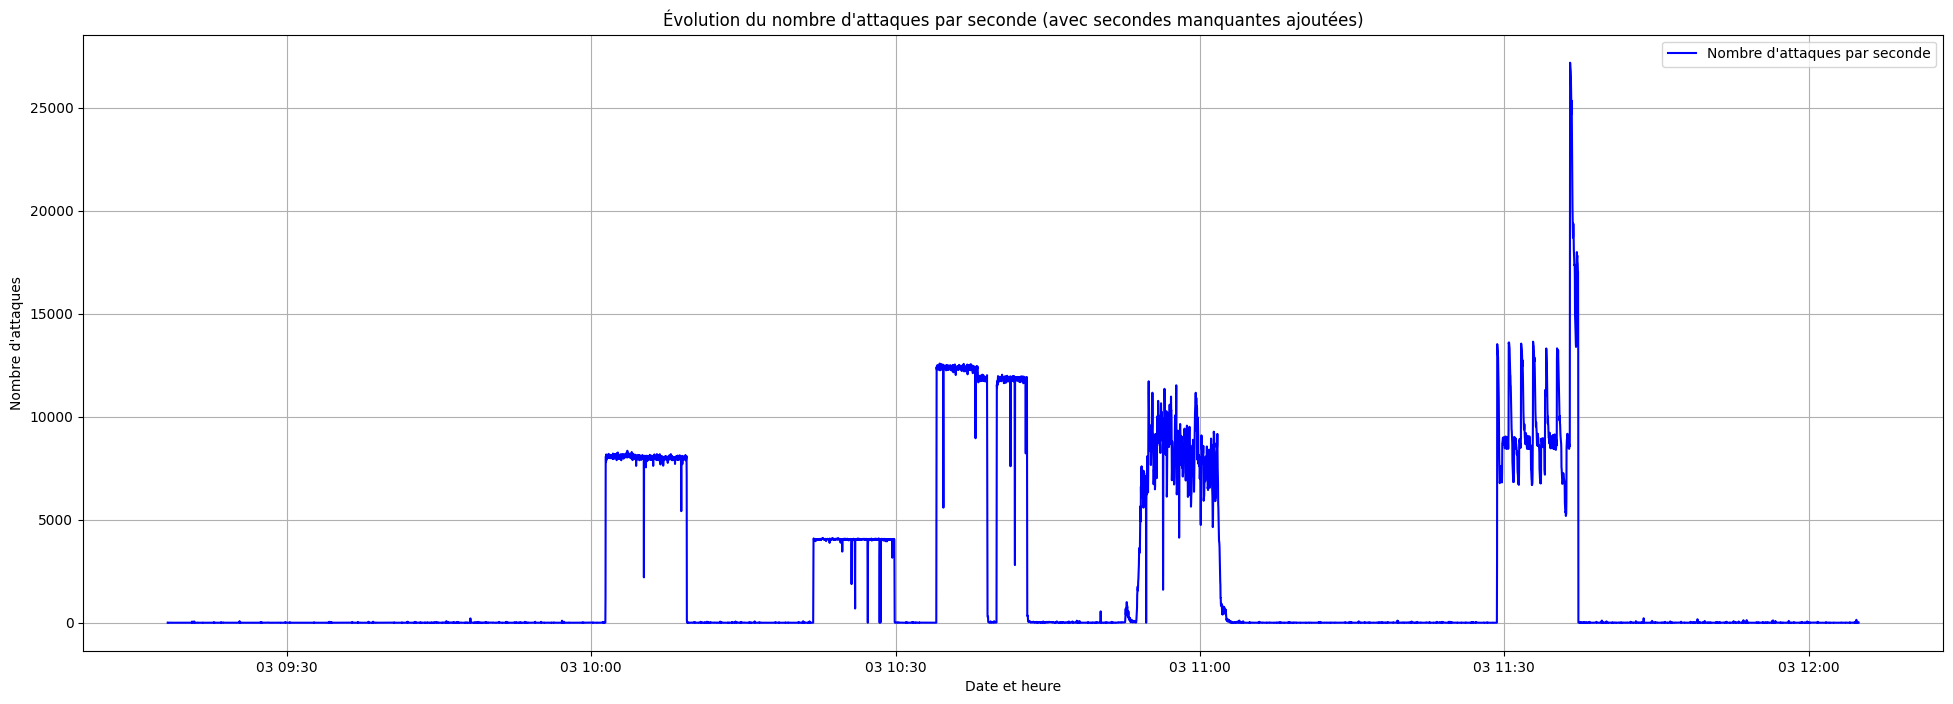

In [ ]:

# Convertir la colonne de dates en datetime si nécessaire
data['ds'] = pd.to_datetime(data['ds'])

# Déterminer la première et la dernière timestamp dans vos données existantes
start_time = data['ds'].min()
end_time = data['ds'].max()

# Générer une séquence de toutes les secondes entre le début et la fin
all_seconds = pd.date_range(start=start_time, end=end_time, freq='S')

# Créer un DataFrame avec toutes les secondes et fusionner avec vos données existantes
all_data = pd.DataFrame({'ds': all_seconds})

# Convertir la colonne de dates en datetime
all_data['ds'] = pd.to_datetime(all_data['ds'])

# Fusionner les données
merged_data = pd.merge(all_data, data, on='ds', how='left')

# Remplacer les NaN par 0 si vous voulez marquer les secondes sans attaque comme 0
merged_data['y'] = merged_data['y'].fillna(0)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 8))
plt.plot(merged_data['ds'][0:10000], merged_data['y'][0:10000], linestyle='-', color='b', label='Nombre d\'attaques par seconde')
plt.title('Évolution du nombre d\'attaques par seconde (avec secondes manquantes ajoutées)')
plt.xlabel('Date et heure')
plt.ylabel('Nombre d\'attaques')
plt.grid(True)
plt.legend()
plt.show()

# RNN Simple

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

# Assurez-vous que la variable 'data' est définie avant de copier
df = merged_data[0:10000].copy()

# Conversion des dates
df['ds'] = pd.to_datetime(df['ds'])

# Normaliser les données
scaler = MinMaxScaler()
df['y'] = scaler.fit_transform(df[['y']])

seq_length = 20

# Diviser les données en ensembles d'entraînement et de test
train, test = train_test_split(df, test_size=0.4, shuffle=False)

# Créer des générateurs de séquences temporelles
train_generator = TimeseriesGenerator(train['y'].values, train['y'].values, length=seq_length, batch_size=1)
test_generator = TimeseriesGenerator(test['y'].values, test['y'].values, length=seq_length, batch_size=1)

# Définir le modèle RNN simple
model = Sequential()
model.add(SimpleRNN(50, activation='relu', return_sequences=False, input_shape=(seq_length, 1)))
#model.add(SimpleRNN(20, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entraîner le modèle
history = model.fit(train_generator, epochs=20, verbose=2)

# Faire des prédictions
train_predictions = model.predict(train_generator)
test_predictions = model.predict(test_generator)

# Inverser la normalisation
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

# Les vraies valeurs doivent être extraites du DataFrame et remodelées
y_train_true = scaler.inverse_transform(train['y'].values[seq_length:].reshape(-1, 1))
y_test_true = scaler.inverse_transform(test['y'].values[seq_length:].reshape(-1, 1))


Epoch 1/20
5980/5980 - 30s - loss: 7.1694e-04 - 30s/epoch - 5ms/step
Epoch 2/20
5980/5980 - 28s - loss: 3.4516e-04 - 28s/epoch - 5ms/step
Epoch 3/20
5980/5980 - 27s - loss: 3.0782e-04 - 27s/epoch - 5ms/step
Epoch 4/20
5980/5980 - 29s - loss: 2.9317e-04 - 29s/epoch - 5ms/step
Epoch 5/20
5980/5980 - 30s - loss: 2.9476e-04 - 30s/epoch - 5ms/step
Epoch 6/20
5980/5980 - 30s - loss: 2.9410e-04 - 30s/epoch - 5ms/step
Epoch 7/20
5980/5980 - 28s - loss: 2.8038e-04 - 28s/epoch - 5ms/step
Epoch 8/20
5980/5980 - 28s - loss: 2.7130e-04 - 28s/epoch - 5ms/step
Epoch 9/20
5980/5980 - 28s - loss: 2.7417e-04 - 28s/epoch - 5ms/step
Epoch 10/20
5980/5980 - 28s - loss: 2.7484e-04 - 28s/epoch - 5ms/step
Epoch 11/20
5980/5980 - 28s - loss: 2.7005e-04 - 28s/epoch - 5ms/step
Epoch 12/20
5980/5980 - 27s - loss: 2.7161e-04 - 27s/epoch - 4ms/step
Epoch 13/20
5980/5980 - 27s - loss: 2.6494e-04 - 27s/epoch - 5ms/step
Epoch 14/20
5980/5980 - 27s - loss: 2.6549e-04 - 27s/epoch - 4ms/step
Epoch 15/20
5980/5980 - 28s -

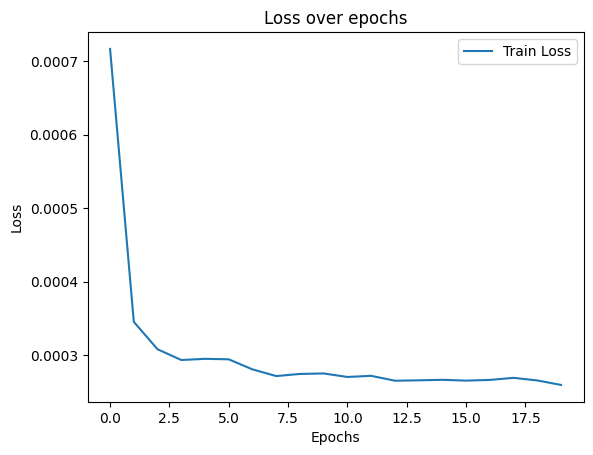

In [ ]:
import matplotlib.pyplot as plt

# Plot de la perte sur l'ensemble d'entraînement
plt.plot(history.history['loss'], label='Train Loss')
# Vérifier si vous avez aussi la perte sur l'ensemble de validation
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import r2_score
# Calculer le R^2
r2 = r2_score(y_train_true, train_predictions)
print(f"R²: {r2}")



from sklearn.metrics import mean_squared_error
# Calcul de la MSE
mse = mean_squared_error(y_train_true, train_predictions)

# Calcul de la RMSE
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

R²: 0.9884908328226008
RMSE: 427.45715684924926


In [ ]:
from sklearn.metrics import r2_score
# Calculer le R^2
r2 = r2_score(y_test_true, test_predictions)
print(f"R²: {r2}")



from sklearn.metrics import mean_squared_error
# Calcul de la MSE
mse = mean_squared_error(y_test_true, test_predictions)

# Calcul de la RMSE
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

R²: 0.9895928941592355
RMSE: 389.8664296846944


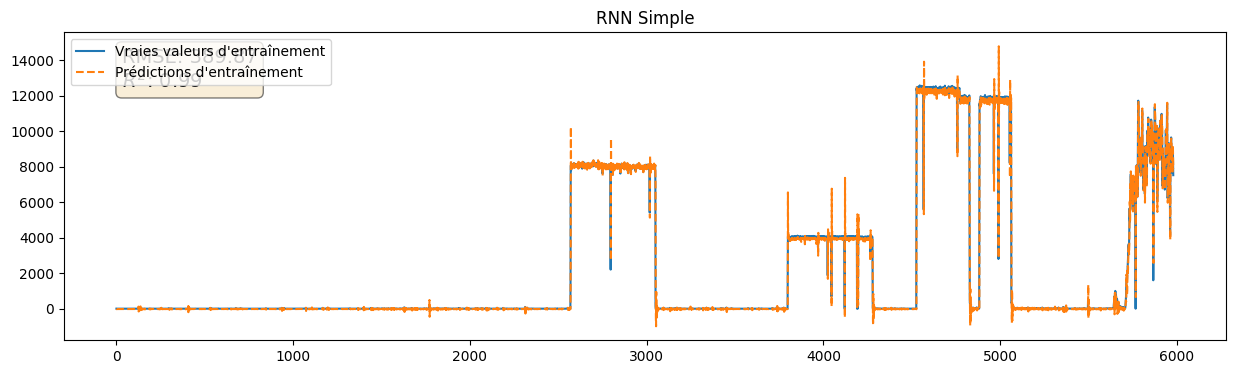

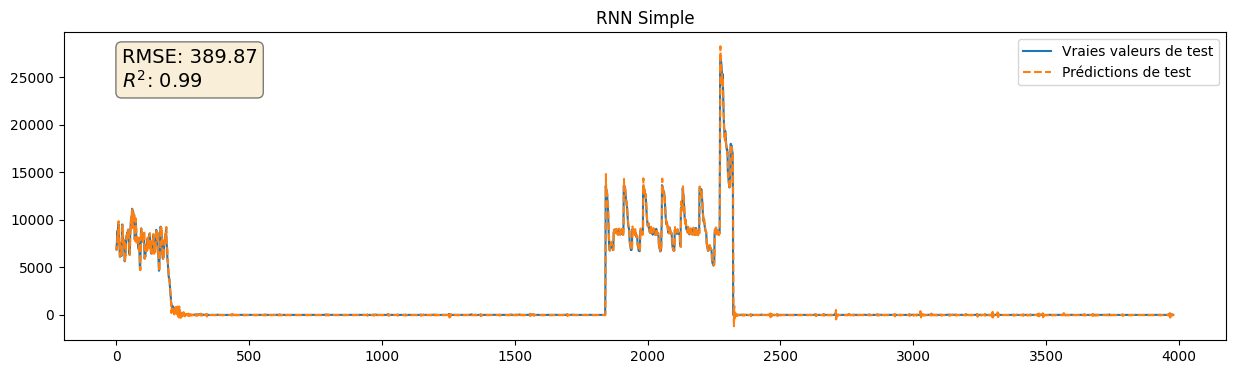

In [ ]:
# Visualiser les résultats
plt.figure(figsize=(15, 4))

#plt.subplot(1, 2, 1)
plt.plot(y_train_true, label='Vraies valeurs d\'entraînement')
plt.plot(train_predictions, label='Prédictions d\'entraînement',linestyle='--')
plt.title('RNN Simple')
#plt.ylim(0, 1000)  # Définir l'échelle entre 0 et 1000
plt.legend()


# Ajout des annotations RMSE et R^2 dans la figure
textstr = f'RMSE: {np.sqrt(mse):.2f}\n$R^2$: {r2:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.show()

plt.figure(figsize=(15, 4))
#plt.subplot(1, 2, 2)
plt.plot(y_test_true, label='Vraies valeurs de test')
plt.plot(test_predictions, label='Prédictions de test',linestyle='--')
plt.title('RNN Simple')
#plt.ylim(0, 1000)  # Définir l'échelle entre 0 et 1000
plt.legend()

# Ajout des annotations RMSE et R^2 dans la figure
textstr = f'RMSE: {np.sqrt(mse):.2f}\n$R^2$: {r2:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.show()

# LSTM

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense,LSTM

df=merged_data[0:10000].copy()

df['ds'] = pd.to_datetime(df['ds'])

# Normaliser les données
scaler = MinMaxScaler()
df['y'] = scaler.fit_transform(df[['y']])

# Créer des séquences temporelles
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 20
X, y = create_sequences(df['y'].values, seq_length)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

# Reshape les données pour RNN (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Définir le modèle RNN simple
model = Sequential()
model.add(LSTM(50, input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entraîner le modèle
history = model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=2)
#history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.8)
# Faire des prédictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverser la normalisation
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_true = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))



Epoch 1/20
5988/5988 - 39s - loss: 5.6311e-04 - 39s/epoch - 7ms/step
Epoch 2/20
5988/5988 - 36s - loss: 3.3821e-04 - 36s/epoch - 6ms/step
Epoch 3/20
5988/5988 - 37s - loss: 3.2823e-04 - 37s/epoch - 6ms/step
Epoch 4/20
5988/5988 - 36s - loss: 3.1771e-04 - 36s/epoch - 6ms/step
Epoch 5/20
5988/5988 - 38s - loss: 3.0847e-04 - 38s/epoch - 6ms/step
Epoch 6/20
5988/5988 - 36s - loss: 3.0074e-04 - 36s/epoch - 6ms/step
Epoch 7/20
5988/5988 - 38s - loss: 3.0338e-04 - 38s/epoch - 6ms/step
Epoch 8/20
5988/5988 - 36s - loss: 3.0001e-04 - 36s/epoch - 6ms/step
Epoch 9/20
5988/5988 - 37s - loss: 2.9899e-04 - 37s/epoch - 6ms/step
Epoch 10/20
5988/5988 - 36s - loss: 2.9452e-04 - 36s/epoch - 6ms/step
Epoch 11/20
5988/5988 - 38s - loss: 2.9184e-04 - 38s/epoch - 6ms/step
Epoch 12/20
5988/5988 - 36s - loss: 2.8757e-04 - 36s/epoch - 6ms/step
Epoch 13/20
5988/5988 - 39s - loss: 2.9032e-04 - 39s/epoch - 6ms/step
Epoch 14/20
5988/5988 - 38s - loss: 2.8416e-04 - 38s/epoch - 6ms/step
Epoch 15/20
5988/5988 - 39s -

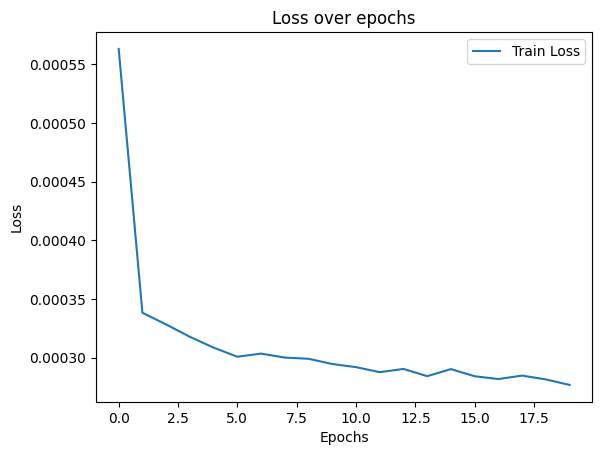

In [ ]:
import matplotlib.pyplot as plt

# Plot de la perte sur l'ensemble d'entraînement
plt.plot(history.history['loss'], label='Train Loss')
# Vérifier si vous avez aussi la perte sur l'ensemble de validation
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

# Assurez-vous que la variable 'data' est définie avant de copier
df = merged_data[0:10000].copy()

# Conversion des dates
df['ds'] = pd.to_datetime(df['ds'])

# Normaliser les données
scaler = MinMaxScaler()
df['y'] = scaler.fit_transform(df[['y']])

seq_length = 20

# Diviser les données en ensembles d'entraînement et de test
train, test = train_test_split(df, test_size=0.4, shuffle=False)

# Créer des générateurs de séquences temporelles
train_generator = TimeseriesGenerator(train['y'].values, train['y'].values, length=seq_length, batch_size=1)
test_generator = TimeseriesGenerator(test['y'].values, test['y'].values, length=seq_length, batch_size=1)

# Définir le modèle RNN simple
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=False, input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entraîner le modèle
history = model.fit(train_generator, epochs=20, verbose=2)

# Faire des prédictions
train_predictions = model.predict(train_generator)
test_predictions = model.predict(test_generator)

# Inverser la normalisation
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

# Les vraies valeurs doivent être extraites du DataFrame et remodelées
y_train_true = scaler.inverse_transform(train['y'].values[seq_length:].reshape(-1, 1))
y_test_true = scaler.inverse_transform(test['y'].values[seq_length:].reshape(-1, 1))


Epoch 1/20
5980/5980 - 45s - loss: 7.6941e-04 - 45s/epoch - 8ms/step
Epoch 2/20
5980/5980 - 45s - loss: 4.0499e-04 - 45s/epoch - 7ms/step
Epoch 3/20
5980/5980 - 44s - loss: 3.3762e-04 - 44s/epoch - 7ms/step
Epoch 4/20
5980/5980 - 44s - loss: 3.2200e-04 - 44s/epoch - 7ms/step
Epoch 5/20
5980/5980 - 43s - loss: 2.9708e-04 - 43s/epoch - 7ms/step
Epoch 6/20
5980/5980 - 43s - loss: 2.9264e-04 - 43s/epoch - 7ms/step
Epoch 7/20
5980/5980 - 43s - loss: 2.9424e-04 - 43s/epoch - 7ms/step
Epoch 8/20
5980/5980 - 43s - loss: 2.8856e-04 - 43s/epoch - 7ms/step
Epoch 9/20
5980/5980 - 43s - loss: 2.8273e-04 - 43s/epoch - 7ms/step
Epoch 10/20
5980/5980 - 43s - loss: 2.8322e-04 - 43s/epoch - 7ms/step
Epoch 11/20
5980/5980 - 45s - loss: 2.8035e-04 - 45s/epoch - 8ms/step
Epoch 12/20
5980/5980 - 43s - loss: 2.8285e-04 - 43s/epoch - 7ms/step
Epoch 13/20
5980/5980 - 43s - loss: 2.8736e-04 - 43s/epoch - 7ms/step
Epoch 14/20
5980/5980 - 44s - loss: 2.7675e-04 - 44s/epoch - 7ms/step
Epoch 15/20
5980/5980 - 43s -

In [ ]:
from sklearn.metrics import r2_score
# Calculer le R^2
r2 = r2_score(y_train_true, train_predictions)
print(f"R²: {r2}")



from sklearn.metrics import mean_squared_error
# Calcul de la MSE
mse = mean_squared_error(y_train_true, train_predictions)

# Calcul de la RMSE
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

R²: 0.9792165681135243
RMSE: 574.4196325085493


In [ ]:
from sklearn.metrics import r2_score
# Calculer le R^2
r2 = r2_score(y_test_true, test_predictions)
print(f"R²: {r2}")



from sklearn.metrics import mean_squared_error
# Calcul de la MSE
mse = mean_squared_error(y_test_true, test_predictions)

# Calcul de la RMSE
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

R²: 0.9755923771838566
RMSE: 597.0539788259234


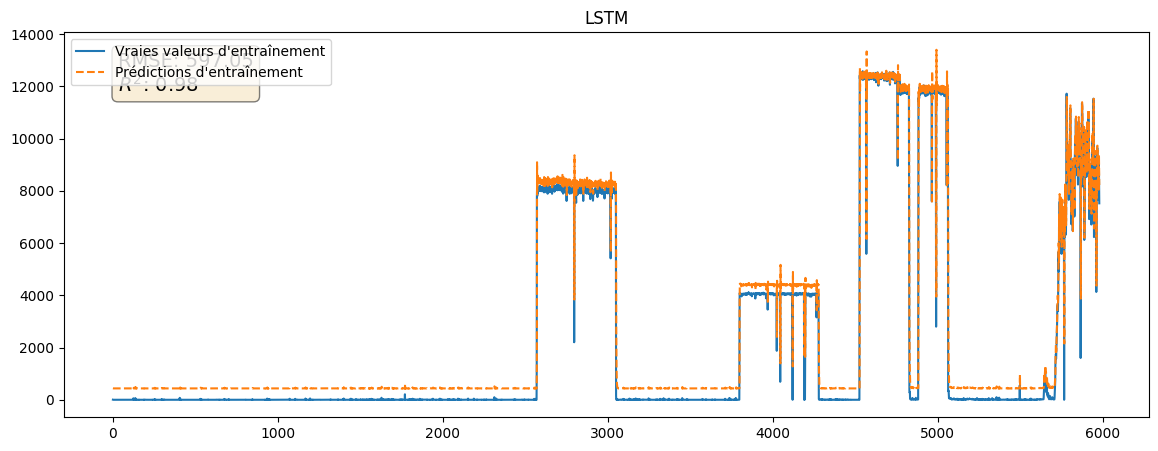

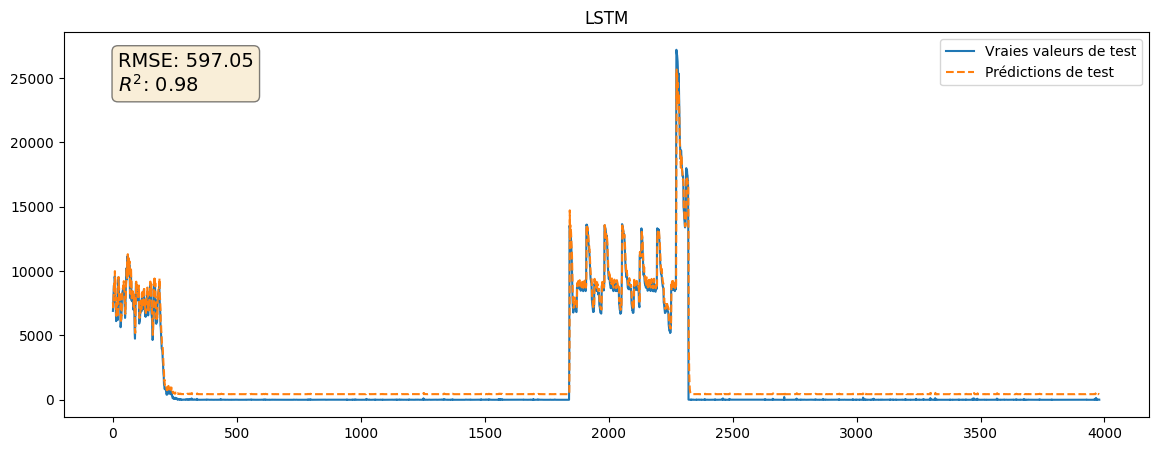

In [ ]:
# Visualiser les résultats
plt.figure(figsize=(14, 5))

#plt.subplot(1, 2, 1)
plt.plot(y_train_true, label='Vraies valeurs d\'entraînement')
plt.plot(train_predictions, label='Prédictions d\'entraînement',linestyle='--')
plt.title('LSTM')
#plt.ylim(0, 1000)  # Définir l'échelle entre 0 et 1000
plt.legend()

# Ajout des annotations RMSE et R^2 dans la figure
textstr = f'RMSE: {np.sqrt(mse):.2f}\n$R^2$: {r2:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.show()

plt.figure(figsize=(14, 5))
#plt.subplot(1, 2, 2)
plt.plot(y_test_true, label='Vraies valeurs de test')
plt.plot(test_predictions, label='Prédictions de test',linestyle='--')
plt.title('LSTM')
#plt.ylim(0, 1000)  # Définir l'échelle entre 0 et 1000
plt.legend()

# Ajout des annotations RMSE et R^2 dans la figure
textstr = f'RMSE: {np.sqrt(mse):.2f}\n$R^2$: {r2:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.show()

# GRU

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense,LSTM,GRU

df=merged_data[0:10000].copy()

df['ds'] = pd.to_datetime(df['ds'])

# Normaliser les données
scaler = MinMaxScaler()
df['y'] = scaler.fit_transform(df[['y']])

# Créer des séquences temporelles
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 20
X, y = create_sequences(df['y'].values, seq_length)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

# Reshape les données pour RNN (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Définir le modèle RNN simple
model = Sequential()
model.add(GRU(50, input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entraîner le modèle
history=model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=2)
#history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.8)
# Faire des prédictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverser la normalisation
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_true = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/20
5988/5988 - 41s - loss: 4.4503e-04 - 41s/epoch - 7ms/step
Epoch 2/20
5988/5988 - 38s - loss: 3.3290e-04 - 38s/epoch - 6ms/step
Epoch 3/20
5988/5988 - 39s - loss: 3.2726e-04 - 39s/epoch - 6ms/step
Epoch 4/20
5988/5988 - 39s - loss: 3.1521e-04 - 39s/epoch - 7ms/step
Epoch 5/20
5988/5988 - 39s - loss: 3.1195e-04 - 39s/epoch - 6ms/step
Epoch 6/20
5988/5988 - 40s - loss: 3.1134e-04 - 40s/epoch - 7ms/step
Epoch 7/20
5988/5988 - 39s - loss: 3.0215e-04 - 39s/epoch - 7ms/step
Epoch 8/20
5988/5988 - 39s - loss: 3.0128e-04 - 39s/epoch - 7ms/step
Epoch 9/20
5988/5988 - 39s - loss: 2.9354e-04 - 39s/epoch - 7ms/step
Epoch 10/20
5988/5988 - 42s - loss: 2.9643e-04 - 42s/epoch - 7ms/step
Epoch 11/20
5988/5988 - 42s - loss: 2.9234e-04 - 42s/epoch - 7ms/step
Epoch 12/20
5988/5988 - 43s - loss: 2.9570e-04 - 43s/epoch - 7ms/step
Epoch 13/20
5988/5988 - 43s - loss: 2.9523e-04 - 43s/epoch - 7ms/step
Epoch 14/20
5988/5988 - 42s - loss: 2.8896e-04 - 42s/epoch - 7ms/step
Epoch 15/20
5988/5988 - 42s -

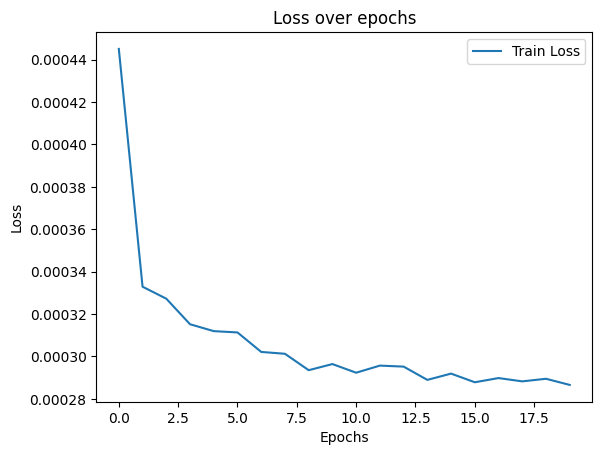

In [ ]:
import matplotlib.pyplot as plt

# Plot de la perte sur l'ensemble d'entraînement
plt.plot(history.history['loss'], label='Train Loss')
# Vérifier si vous avez aussi la perte sur l'ensemble de validation
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

# Assurez-vous que la variable 'data' est définie avant de copier
df = merged_data[0:10000].copy()

# Conversion des dates
df['ds'] = pd.to_datetime(df['ds'])

# Normaliser les données
scaler = MinMaxScaler()
df['y'] = scaler.fit_transform(df[['y']])

seq_length = 20

# Diviser les données en ensembles d'entraînement et de test
train, test = train_test_split(df, test_size=0.4, shuffle=False)

# Créer des générateurs de séquences temporelles
train_generator = TimeseriesGenerator(train['y'].values, train['y'].values, length=seq_length, batch_size=1)
test_generator = TimeseriesGenerator(test['y'].values, test['y'].values, length=seq_length, batch_size=1)

# Définir le modèle RNN simple
model = Sequential()
model.add(GRU(50, activation='relu', return_sequences=False, input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entraîner le modèle
history = model.fit(train_generator, epochs=20, verbose=2)

# Faire des prédictions
train_predictions = model.predict(train_generator)
test_predictions = model.predict(test_generator)

# Inverser la normalisation
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

# Les vraies valeurs doivent être extraites du DataFrame et remodelées
y_train_true = scaler.inverse_transform(train['y'].values[seq_length:].reshape(-1, 1))
y_test_true = scaler.inverse_transform(test['y'].values[seq_length:].reshape(-1, 1))


Epoch 1/20
5980/5980 - 50s - loss: 6.5563e-04 - 50s/epoch - 8ms/step
Epoch 2/20
5980/5980 - 49s - loss: 3.5574e-04 - 49s/epoch - 8ms/step
Epoch 3/20
5980/5980 - 47s - loss: 3.2040e-04 - 47s/epoch - 8ms/step
Epoch 4/20
5980/5980 - 46s - loss: 3.1722e-04 - 46s/epoch - 8ms/step
Epoch 5/20
5980/5980 - 46s - loss: 3.0736e-04 - 46s/epoch - 8ms/step
Epoch 6/20
5980/5980 - 48s - loss: 2.9908e-04 - 48s/epoch - 8ms/step
Epoch 7/20
5980/5980 - 50s - loss: 2.9279e-04 - 50s/epoch - 8ms/step
Epoch 8/20
5980/5980 - 48s - loss: 2.9738e-04 - 48s/epoch - 8ms/step
Epoch 9/20
5980/5980 - 47s - loss: 2.8967e-04 - 47s/epoch - 8ms/step
Epoch 10/20
5980/5980 - 48s - loss: 2.9523e-04 - 48s/epoch - 8ms/step
Epoch 11/20
5980/5980 - 48s - loss: 2.8144e-04 - 48s/epoch - 8ms/step
Epoch 12/20
5980/5980 - 51s - loss: 2.8986e-04 - 51s/epoch - 9ms/step
Epoch 13/20
5980/5980 - 49s - loss: 2.8587e-04 - 49s/epoch - 8ms/step
Epoch 14/20
5980/5980 - 52s - loss: 2.8434e-04 - 52s/epoch - 9ms/step
Epoch 15/20
5980/5980 - 50s -

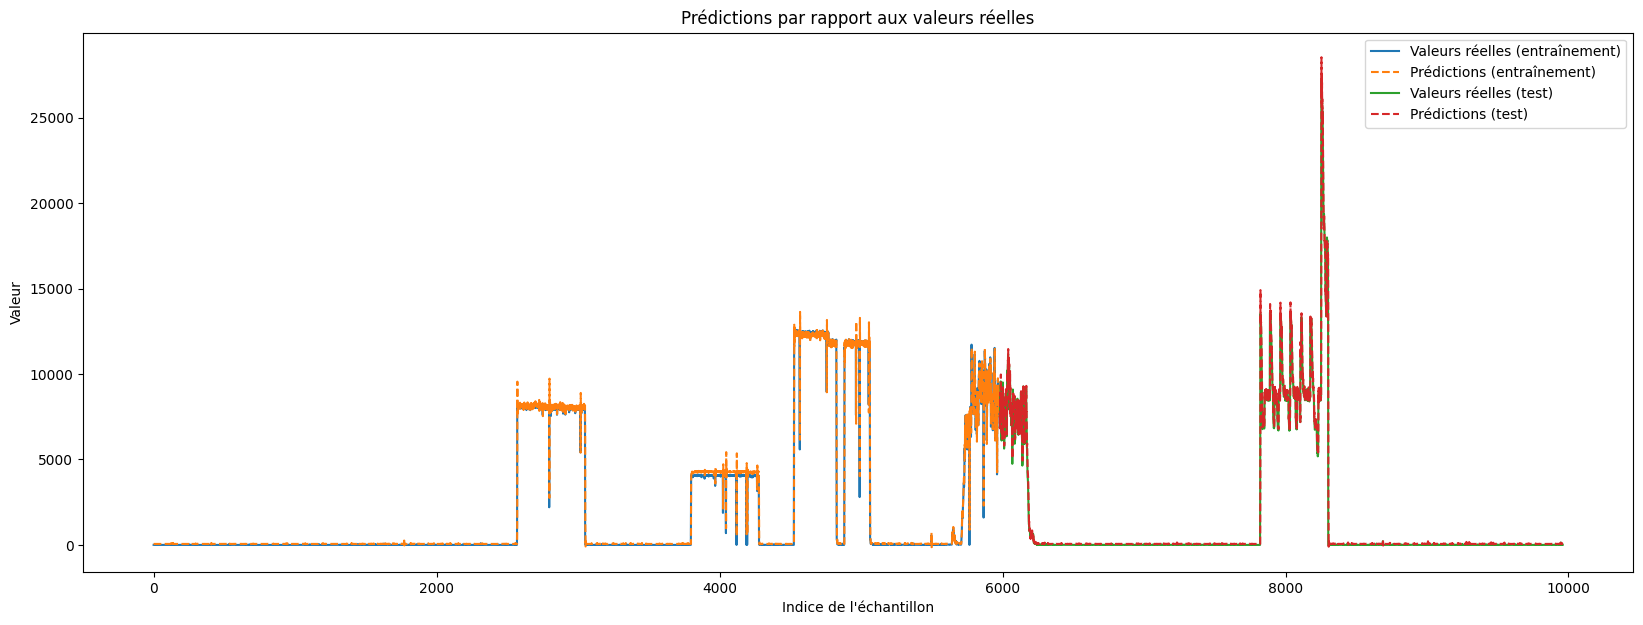

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 7))

# Plot des données d'entraînement
plt.plot(y_train_true, label='Valeurs réelles (entraînement)')
plt.plot(train_predictions, label='Prédictions (entraînement)',linestyle='--')

# Plot des données de test
plt.plot(range(len(y_train_true), len(y_train_true) + len(y_test_true)), y_test_true, label='Valeurs réelles (test)')
plt.plot(range(len(y_train_true), len(y_train_true) + len(y_test_true)), test_predictions, label='Prédictions (test)', linestyle='--')

plt.legend()
plt.title('Prédictions par rapport aux valeurs réelles')
plt.xlabel('Indice de l\'échantillon')
plt.ylabel('Valeur')
plt.show()

In [ ]:
from sklearn.metrics import r2_score
# Calculer le R^2
r2 = r2_score(y_train_true, train_predictions)
print(f"R²: {r2}")



from sklearn.metrics import mean_squared_error
# Calcul de la MSE
mse = mean_squared_error(y_train_true, train_predictions)

# Calcul de la RMSE
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

R²: 0.9885306823442126
RMSE: 426.7164979816578


In [ ]:
from sklearn.metrics import r2_score
# Calculer le R^2
r2 = r2_score(y_test_true, test_predictions)
print(f"R²: {r2}")



from sklearn.metrics import mean_squared_error
# Calcul de la MSE
mse = mean_squared_error(y_test_true, test_predictions)

# Calcul de la RMSE
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

R²: 0.9881746850468347
RMSE: 415.58246377090853


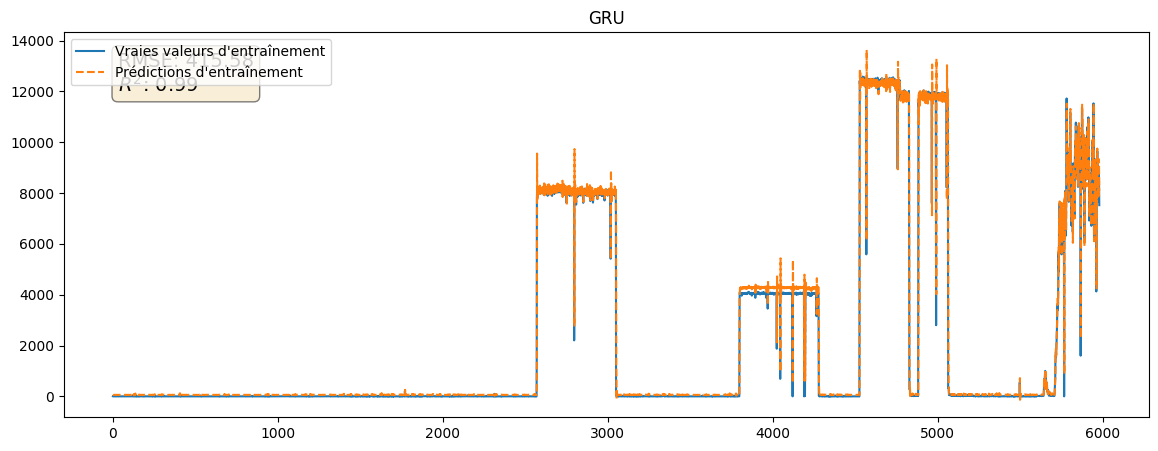

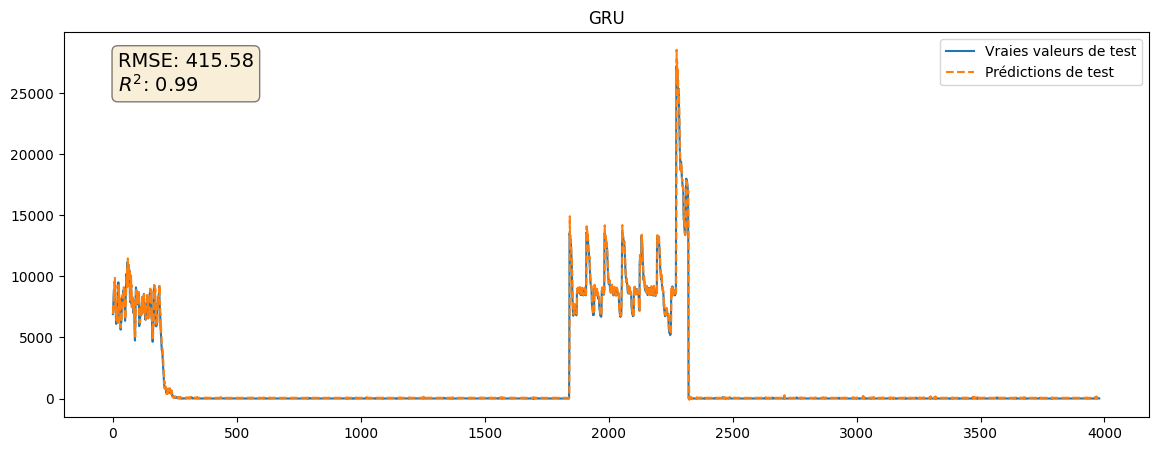

In [ ]:
# Visualiser les résultats
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 5))

#plt.subplot(1, 2, 1)
plt.plot(y_train_true, label='Vraies valeurs d\'entraînement')
plt.plot(train_predictions, label='Prédictions d\'entraînement',linestyle='--')
plt.title('GRU')
#plt.ylim(0, 1000)  # Définir l'échelle entre 0 et 1000
plt.legend()

# Ajout des annotations RMSE et R^2 dans la figure
textstr = f'RMSE: {np.sqrt(mse):.2f}\n$R^2$: {r2:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.show()

plt.figure(figsize=(14, 5))
#plt.subplot(1, 2, 2)
plt.plot(y_test_true, label='Vraies valeurs de test',linestyle='-')
plt.plot(test_predictions, label='Prédictions de test',linestyle='--')
plt.title('GRU')
#plt.ylim(0, 1000)  # Définir l'échelle entre 0 et 1000
plt.legend()

# Ajout des annotations RMSE et R^2 dans la figure
textstr = f'RMSE: {np.sqrt(mse):.2f}\n$R^2$: {r2:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.show()

# LSTM short and long terme prediction

In [ ]:
## avec dropout avec et deux couche LSTM

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Supposons que 'data' est déjà un DataFrame contenant les colonnes 'ds' et 'y'
df = merged_data[0:10000].copy()

# Convertir les dates en format datetime
df['ds'] = pd.to_datetime(df['ds'])

# Normaliser les données
scaler = MinMaxScaler()
df['y'] = scaler.fit_transform(df[['y']])

# Créer des séquences temporelles
def create_sequences(data, seq_length, long_term_offset):
    X = []
    y_short_term = []
    y_long_term = []
    for i in range(len(data) - seq_length - long_term_offset):
        X.append(data[i:i+seq_length])
        y_short_term.append(data[i+seq_length])
        y_long_term.append(data[i+seq_length + long_term_offset])
    return np.array(X), np.array(y_short_term), np.array(y_long_term)

seq_length = 20
long_term_offset = 20  # Ajustez cela selon vos besoins
X, y_short_term, y_long_term = create_sequences(df['y'].values, seq_length, long_term_offset)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train_short, y_test_short, y_train_long, y_test_long = train_test_split(
    X, y_short_term, y_long_term, test_size=0.4, shuffle=False)

# Reshape les données pour LSTM (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Définir le modèle LSTM avec deux sorties
def create_lstm_model(seq_length, feature_count):
    inputs = Input(shape=(seq_length, feature_count))

    # Première couche LSTM
    x = LSTM(units=50, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)

    # Deuxième couche LSTM
    x = LSTM(units=50, return_sequences=False)(x)
    x = Dropout(0.2)(x)

    # Prédiction à court terme
    short_term_output = Dense(units=1, name='short_term_output')(x)

    # Prédiction à long terme
    long_term_output = Dense(units=1, name='long_term_output')(x)

    # Création du modèle
    model = Model(inputs=inputs, outputs=[short_term_output, long_term_output])

    # Compilation du modèle
    model.compile(optimizer=Adam(), loss='mean_squared_error')

    return model

# Exemple d'utilisation
feature_count = 1  # nombre de caractéristiques (une seule caractéristique pour les séries temporelles simples)
model = create_lstm_model(seq_length, feature_count)

# Affichage de la structure du modèle
model.summary()

# Entraînement du modèle
history = model.fit(
    X_train,
    {'short_term_output': y_train_short, 'long_term_output': y_train_long},
    epochs=30, batch_size=1, verbose=2,
    validation_data=(X_test, {'short_term_output': y_test_short, 'long_term_output': y_test_long})
)

# Faire des prédictions
train_predictions_short, train_predictions_long = model.predict(X_train)
test_predictions_short, test_predictions_long = model.predict(X_test)

# Inverser la normalisation
train_predictions_short = scaler.inverse_transform(train_predictions_short)
test_predictions_short = scaler.inverse_transform(test_predictions_short)
train_predictions_long = scaler.inverse_transform(train_predictions_long)
test_predictions_long = scaler.inverse_transform(test_predictions_long)

y_train_true_short = scaler.inverse_transform(y_train_short.reshape(-1, 1))
y_test_true_short = scaler.inverse_transform(y_test_short.reshape(-1, 1))
y_train_true_long = scaler.inverse_transform(y_train_long.reshape(-1, 1))
y_test_true_long = scaler.inverse_transform(y_test_long.reshape(-1, 1))





Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 20, 1)]              0         []                            
                                                                                                  
 lstm_7 (LSTM)               (None, 20, 50)               10400     ['input_3[0][0]']             
                                                                                                  
 dropout_3 (Dropout)         (None, 20, 50)               0         ['lstm_7[0][0]']              
                                                                                                  
 lstm_8 (LSTM)               (None, 50)                   20200     ['dropout_3[0][0]']           
                                                                                            

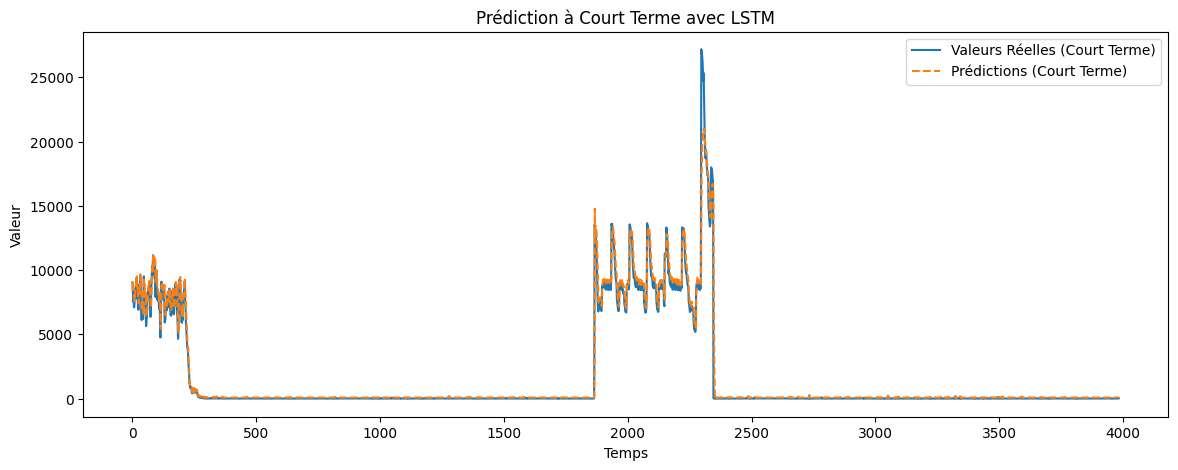

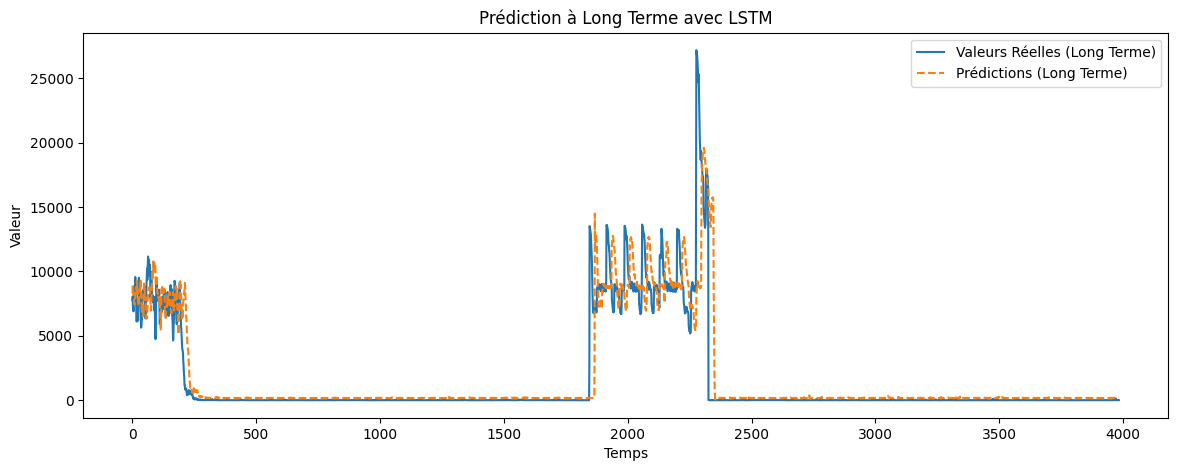

In [ ]:
# Visualisation des résultats
plt.figure(figsize=(14, 5))
plt.plot(y_test_true_short, label='Valeurs Réelles (Court Terme)')
plt.plot(test_predictions_short, label='Prédictions (Court Terme)',linestyle='--')
plt.title('Prédiction à Court Terme avec LSTM')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.legend()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(y_test_true_long, label='Valeurs Réelles (Long Terme)')
plt.plot(test_predictions_long, label='Prédictions (Long Terme)',linestyle='--')
plt.title('Prédiction à Long Terme avec LSTM')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.legend()
plt.show()

In [ ]:
# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(y_test_true_short, test_predictions_short)
print(f'RMSE: {np.sqrt(mse)}')

# Calcul du R²
r2 = r2_score(y_test_true_short, test_predictions_short)

print(f'R²: {r2}')

RMSE: 637.2367338722918
R²: 0.9726114305320555


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(y_test_true_long, test_predictions_long)
print(f'RMSE: {np.sqrt(mse)}')

# Calcul du R²
r2 = r2_score(y_test_true_long, test_predictions_long)

print(f'R²: {r2}')

RMSE: 2020.6976201460914
R²: 0.7208226969435536


## avec dropout avec et une seule couche LSTM

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Supposons que 'data' est déjà un DataFrame contenant les colonnes 'ds' et 'y'
df = merged_data[0:10000].copy()

# Convertir les dates en format datetime
df['ds'] = pd.to_datetime(df['ds'])

# Normaliser les données
scaler = MinMaxScaler()
df['y'] = scaler.fit_transform(df[['y']])

# Créer des séquences temporelles
def create_sequences(data, seq_length, long_term_offset):
    X = []
    y_short_term = []
    y_long_term = []
    for i in range(len(data) - seq_length - long_term_offset):
        X.append(data[i:i+seq_length])
        y_short_term.append(data[i+seq_length])
        y_long_term.append(data[i+seq_length + long_term_offset])
    return np.array(X), np.array(y_short_term), np.array(y_long_term)

seq_length = 20
long_term_offset = 20  # Ajustez cela selon vos besoins
X, y_short_term, y_long_term = create_sequences(df['y'].values, seq_length, long_term_offset)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train_short, y_test_short, y_train_long, y_test_long = train_test_split(
    X, y_short_term, y_long_term, test_size=0.4, shuffle=False)

# Reshape les données pour LSTM (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Définir le modèle LSTM avec deux sorties
def create_lstm_model(seq_length, feature_count):
    inputs = Input(shape=(seq_length, feature_count))

    # Première couche LSTM
    x = LSTM(units=50, return_sequences=False)(inputs)
    x = Dropout(0.2)(x)

    # Prédiction à court terme
    short_term_output = Dense(units=1, name='short_term_output')(x)

    # Prédiction à long terme
    long_term_output = Dense(units=1, name='long_term_output')(x)

    # Création du modèle
    model = Model(inputs=inputs, outputs=[short_term_output, long_term_output])

    # Compilation du modèle
    model.compile(optimizer=Adam(), loss='mean_squared_error')

    return model

# Exemple d'utilisation
feature_count = 1  # nombre de caractéristiques (une seule caractéristique pour les séries temporelles simples)
model = create_lstm_model(seq_length, feature_count)

# Affichage de la structure du modèle
model.summary()

# Entraînement du modèle
history = model.fit(
    X_train,
    {'short_term_output': y_train_short, 'long_term_output': y_train_long},
    epochs=30, batch_size=1, verbose=2,
    validation_data=(X_test, {'short_term_output': y_test_short, 'long_term_output': y_test_long})
)

# Faire des prédictions
train_predictions_short, train_predictions_long = model.predict(X_train)
test_predictions_short, test_predictions_long = model.predict(X_test)

# Inverser la normalisation
train_predictions_short = scaler.inverse_transform(train_predictions_short)
test_predictions_short = scaler.inverse_transform(test_predictions_short)
train_predictions_long = scaler.inverse_transform(train_predictions_long)
test_predictions_long = scaler.inverse_transform(test_predictions_long)

y_train_true_short = scaler.inverse_transform(y_train_short.reshape(-1, 1))
y_test_true_short = scaler.inverse_transform(y_test_short.reshape(-1, 1))
y_train_true_long = scaler.inverse_transform(y_train_long.reshape(-1, 1))
y_test_true_long = scaler.inverse_transform(y_test_long.reshape(-1, 1))





Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 20, 1)]              0         []                            
                                                                                                  
 lstm_9 (LSTM)               (None, 50)                   10400     ['input_4[0][0]']             
                                                                                                  
 dropout_5 (Dropout)         (None, 50)                   0         ['lstm_9[0][0]']              
                                                                                                  
 short_term_output (Dense)   (None, 1)                    51        ['dropout_5[0][0]']           
                                                                                            

In [ ]:
# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(y_test_true_short, test_predictions_short)
print(f'Mean Squared Error: {mse}')

# Calcul du R²
r2 = r2_score(y_test_true_short, test_predictions_short)

print(f'R Square: {r2}')

Mean Squared Error: 221207.06916960175
R Square: 0.985080071395929


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(y_test_true_long, test_predictions_long)
print(f'Mean Squared Error: {mse}')

# Calcul du R²
r2 = r2_score(y_test_true_long, test_predictions_long)

print(f'R Square: {r2}')

Mean Squared Error: 3998399.9107240224
R Square: 0.7266219277996246


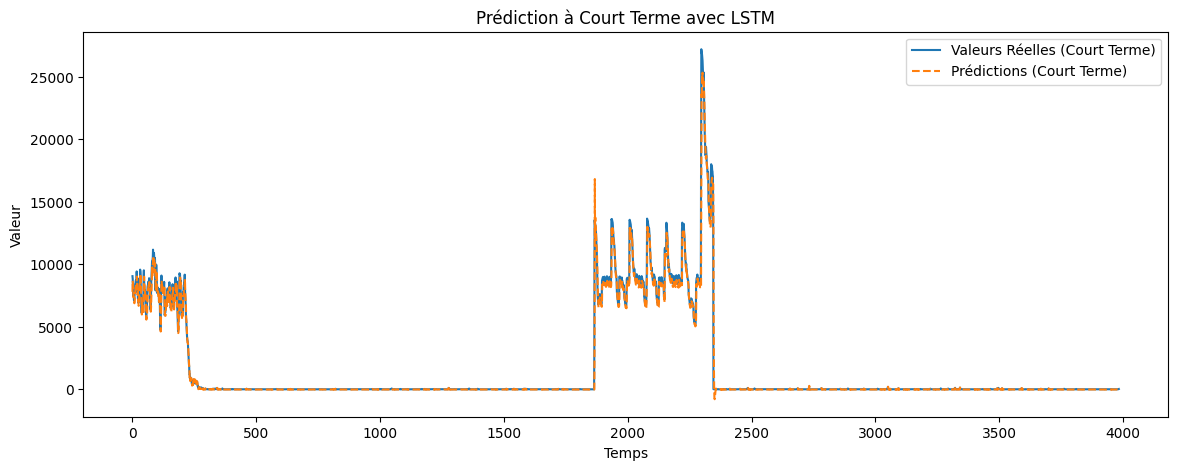

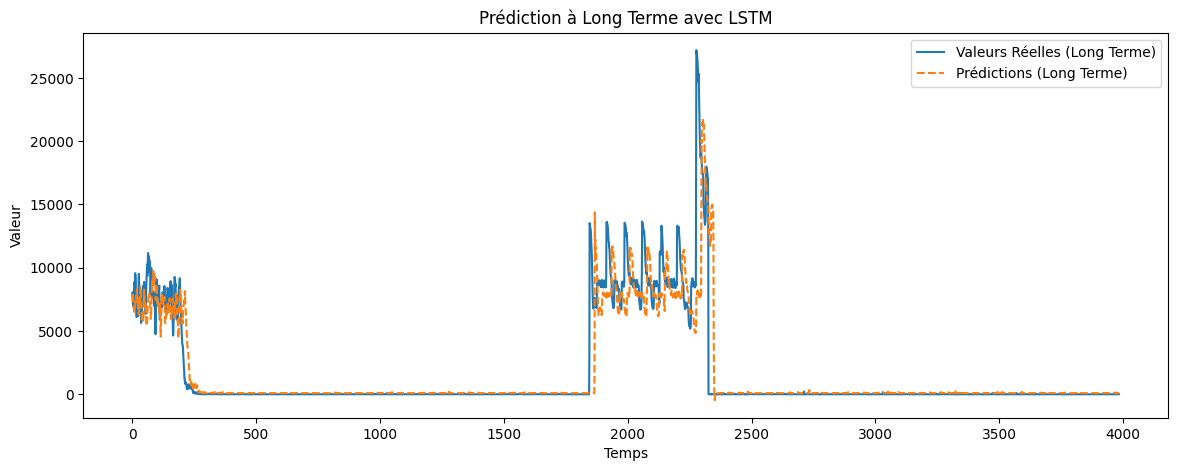

In [ ]:
# Visualisation des résultats
plt.figure(figsize=(14, 5))
plt.plot(y_test_true_short,  label='Valeurs Réelles (Court Terme)')
plt.plot(test_predictions_short,  label='Prédictions (Court Terme)',linestyle='--')
plt.title('Prédiction à Court Terme avec LSTM')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.legend()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(y_test_true_long, label='Valeurs Réelles (Long Terme)')
plt.plot(test_predictions_long, label='Prédictions (Long Terme)',linestyle='--')
plt.title('Prédiction à Long Terme avec LSTM')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.legend()
plt.show()